# Importing the required modules

In [1]:
!pip install split-folders
!pip install pandas numpy matplotlib tensorflow networkx scikit-learn seaborn

In [2]:
import os
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

import random as r

import splitfolders

import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

import networkx as nx
from networkx.algorithms import bipartite

from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

import warnings 
warnings.filterwarnings('ignore')

blended_data_dir = "malware_dataset/"

2024-04-25 11:23:39.137752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 11:23:40.685775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The dataset already comprises train and validation directories with images for each malware. However, we need split the train data images into a train and test dataset for evaluation of the model being trained. Hence, the class takes three inputs: directory of the dataset, percentage of train images, and percentage of test images.

# Exploratory Data Analysis

In [3]:
class MalwareImages:
    
    def __init__(self, DATA_DIR : str, n : int):
        self.DATA_DIR = DATA_DIR
        self.class_distribution = dict()
        self.ROWS = n
        self.COLS = n
    
    def __compute_class_distribution(self):
        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR, malware_type)
            self.class_distribution[malware_type] = len(os.listdir(malware_img_dir))
    
    def plot_class_distribution(self):
        self.__compute_class_distribution()

        malware_classes = list(self.class_distribution.keys())
        malware_class_frequency = list(self.class_distribution.values())
        color_palette = sns.color_palette("pastel")
        plt.figure(figsize=(8,8))
        sns.barplot(y = malware_classes,
                    x = malware_class_frequency,
                    palette = color_palette,
                    edgecolor = "black",
                    orient='h')
        plt.title("Malware Class Distribution")
        plt.xlabel("Malware Class Frequency")
        plt.ylabel("Malware Type")
    
    def malware_samples(self):
        c = 0
        fig, axs = plt.subplots(self.ROWS, self.COLS,figsize=(15,15))

        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR, 
                                           malware_type)
            malware_img_sample = r.choice(list(os.listdir(malware_img_dir)))
            malware_img_sample_path = os.path.join(malware_img_dir, 
                                                   malware_img_sample)
            image = mpimg.imread(malware_img_sample_path)
            axs[c//self.COLS, c%self.COLS].imshow(image, 
                                                  cmap = "gray")
            axs[c//self.COLS, c%self.COLS].set_title(malware_type)
            c += 1
            
        fig.suptitle("Sample for Malware types")
        plt.subplots_adjust(wspace=0.9)
        plt.show()

#### Initialization of the Dataset Loader

In [4]:
train_dataset = MalwareImages(os.path.join(malimg_dir, "train"), 
                              5)

NameError: name 'malimg_dir' is not defined

#### Class Distribution

In [ ]:
train_dataset.plot_class_distribution()

#### Malware Image Samples

In [ ]:
train_dataset.malware_samples()

#### Initialization of the dataset loader

In [ ]:
train_dataset_malevis = MalwareImages(os.path.join(malevis_dir, "test"),
                                      6)

#### Class Distribution

In [ ]:
train_dataset_malevis.plot_class_distribution()

#### Malware Image Samples

In [ ]:
train_dataset_malevis.malware_samples()

## Blended Malware Dataset

#### Initialization of the data loader

In [5]:
train_data_blended = MalwareImages(os.path.join(blended_data_dir, "train"),
                                   6)

#### Class Distribution

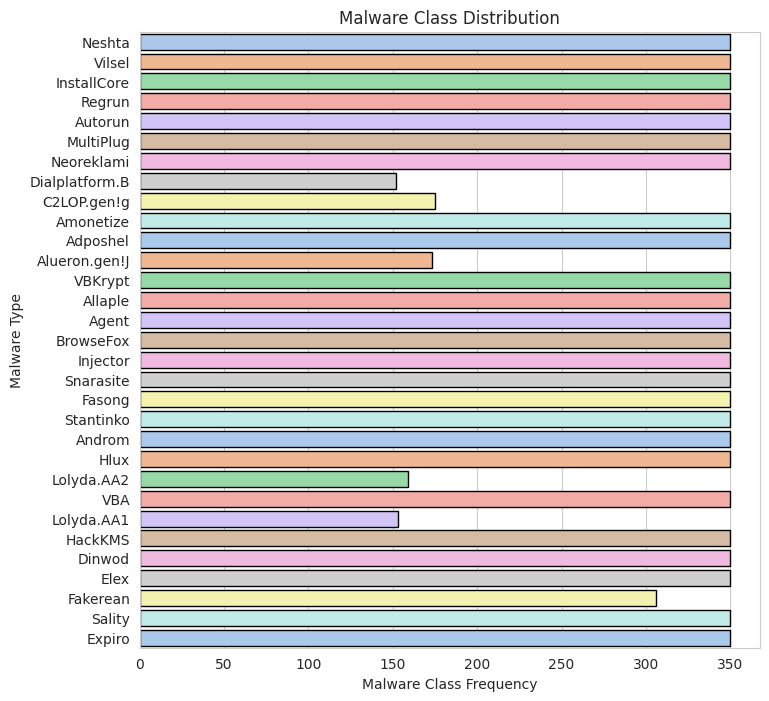

In [6]:
train_data_blended.plot_class_distribution()

#### Malware Image Samples

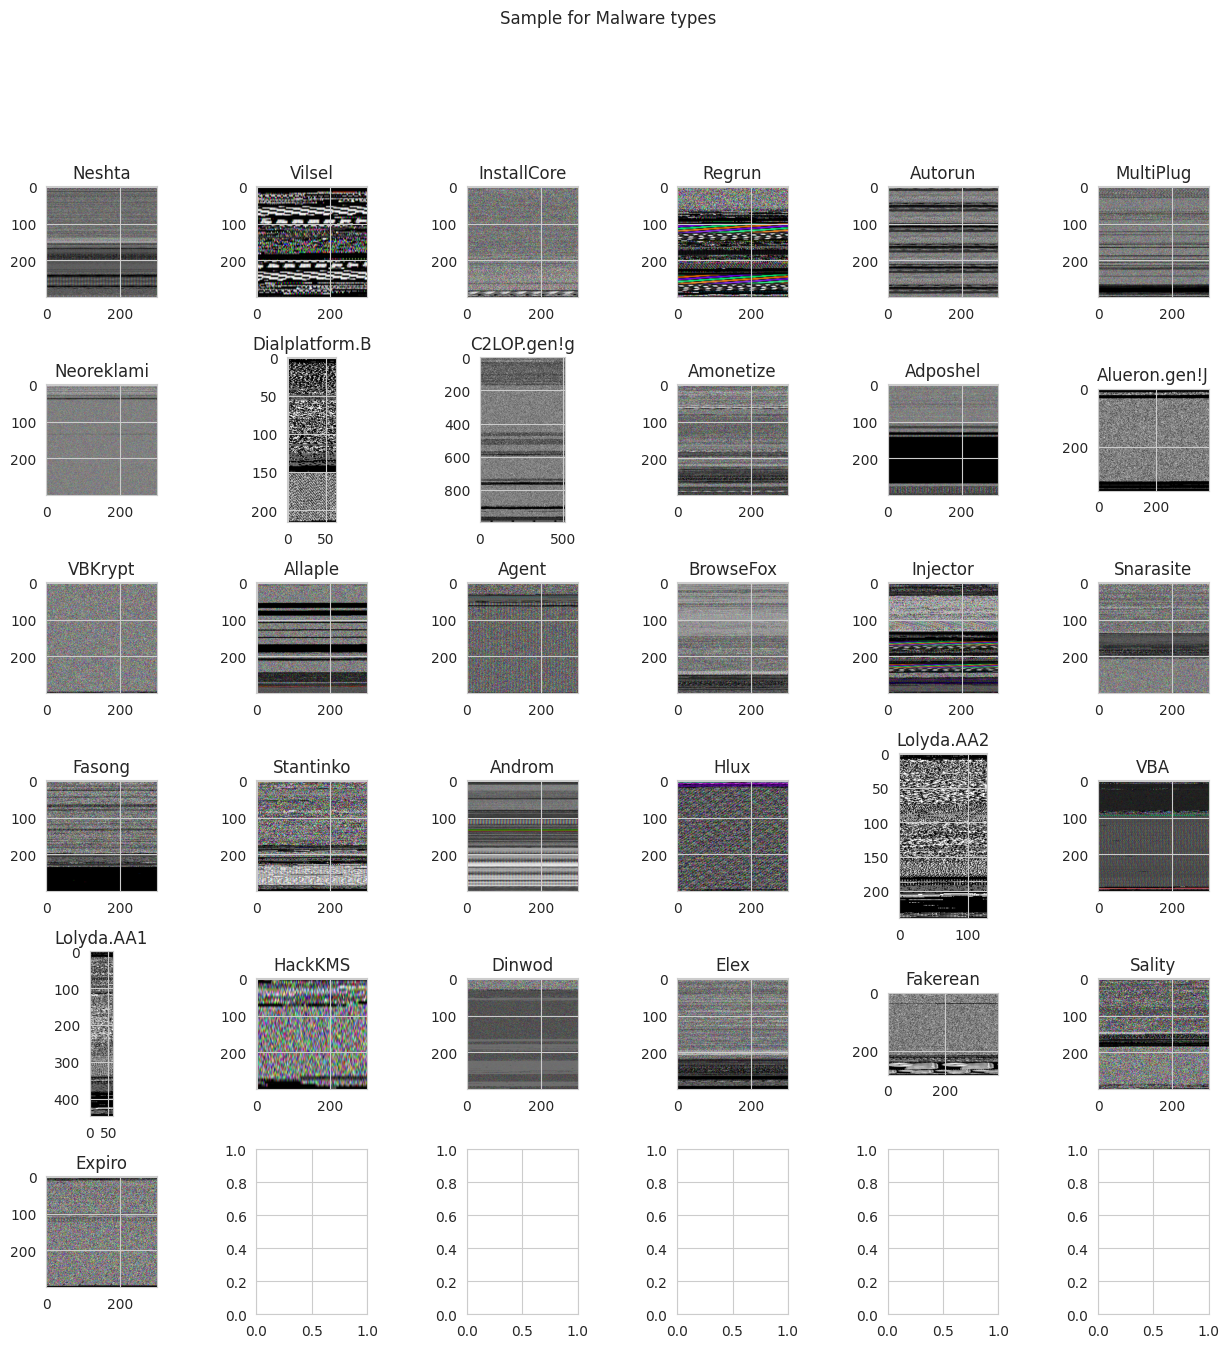

In [7]:
train_data_blended.malware_samples()

## Train-Test Split

In [8]:
def split_dataset(train_data_dir : str, dest_path : str, train_ratio : float, test_ratio : float):

    splitfolders.ratio(input = train_data_dir, 
                       output = dest_path,
                       seed = 1337, 
                       ratio = (train_ratio, 0, test_ratio), 
                       group_prefix = None, 
                       move = False)

In [ ]:
split_dataset(os.path.join(malimg_dir, 
                           "train"),
              "malimg/", 
              0.8, 
              0.2)

In [ ]:
split_dataset(os.path.join(malevis_dir, 
                           "train"),
              "malevis/", 
              0.8, 
              0.2)

#### Blended Dataset

In [9]:
split_dataset(os.path.join(blended_data_dir, 
                           "train"),
              "blended/", 
              0.8, 
              0.2)

# Image Preprocessing

In [10]:
class ImageProcessor:
    
    def __init__(self, model, train_dir : str, test_dir : str, val_dir : str, size, colormode : str) -> None:
        self.cnn_variant = model
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.colormode = colormode
        self.TRAIN_DIR = train_dir
        self.TEST_DIR = test_dir
        self.VAL_DIR = val_dir
        self.size = size
    
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )
        
    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training',
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

# Hyperparameter Tuning and Building CNN Model

In [11]:
class FineTuning:

    def __init__(self, train, val, model, class_count : int, regularize : bool, patience : int) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.CLASSES = class_count
        self.regularize = regularize
        self.patience = patience
    
    def fine_tune(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        if self.regularize == True:
            self.x = Dense(2000, activation='relu')(self.x)
            self.x = Dropout(0.6)(self.x)
            self.x = Dense(1400, activation='relu')(self.x)
            self.x = Dropout(0.5)(self.x)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(self.CLASSES, activation = 'softmax')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", 
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])
    
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=10, 
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=self.patience,
                                            restore_best_weights=True
                                        )
                                     ])

In [12]:
def experiment_model(preprocess_fx, new_data_dir : str,orig_data_dir : str, size, model, nclasses : int, val_dir : str, regularize : bool, patience : int):
    img = ImageProcessor(preprocess_fx, 
                     os.path.join(new_data_dir, "train"),
                     os.path.join(new_data_dir, "test"),
                     os.path.join(orig_data_dir, val_dir),
                     size,
                     "rgb")
    img.create_generators()
    train, val, test = img.get_images()

    learner = FineTuning(train, val,
                         model, nclasses, 
                         regularize, patience)
    learner.fine_tune()
    learner.add_final_layer()
    learner.compile_model()
    learner.train_model()

    return learner.model, learner.history, test

# Model Evaluation

In [13]:
class ModelEvaluator:

    def __init__(self, history, classes : list, model, test):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None
    
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):
        
        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])

        ax.title.set_text(train_metric + " v/s " + val_metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])
    
    def training_history(self):
        rows = 3
        columns = 2
        c = 0
        metrics = ["loss", "accuracy", "auc", "false_positives", "precision", "recall"]

        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric.replace("_", " ").title(), 
                               metric, "val_"+metric)
            c += 1

        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()
    
    def predict(self):
        self.predictions = self.model.predict(self.test)
        self.predictions = list(map(np.argmax, self.predictions))
    
    def class_report(self):
        plt.figure(figsize=(15,15))
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, self.predictions, num_classes=len(self.classes)), 
                    annot=True, cmap="crest")
                    
        print(classification_report(self.test.labels, self.predictions, target_names=self.classes))

In [14]:
blended_models = dict()

## XceptionNet

In [ ]:
model, history, test = experiment_model(cnns.xception,
                                        "malimg",
                                        malimg_dir, 
                                        (75, 75),
                                        cnns.Xception(include_top=False, 
                                                      input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

##### Initialization of evaluator

In [ ]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

In [ ]:
me.training_history()

##### Classification Metrics

In [ ]:
me.predict()
me.class_report()

In [ ]:
model, history, test = experiment_model(cnns.xception,
                                        "malevis",malevis_dir, 
                                        (200, 200),
                                        cnns.Xception(include_top=False, 
                                                      input_shape=(200, 200, 3)), 
                                        25, "val", 
                                        False, 8)

##### Initialization of Evaluator

In [ ]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

In [ ]:
me.training_history()

##### Classification Metrics

In [ ]:
me.predict()
me.class_report()

#### Saving Essential data

In [ ]:
malevis_models["XceptionNet"] = {"Ground Truth": test.labels.tolist(), 
                                 "Predictions":np.array(me.predictions).tolist(), 
                                 "History": history.history}

#### Model Training

In [15]:
model, history, test = experiment_model(cnns.xception,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.Xception(include_top=False, 
                                                      input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

2024-04-25 11:25:26.538439: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.


2024-04-25 11:25:28.819572: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73728000 exceeds 10% of free system memory.
2024-04-25 11:25:28.861124: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73728000 exceeds 10% of free system memory.
2024-04-25 11:25:28.899917: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73728000 exceeds 10% of free system memory.


Epoch 1/10


2024-04-25 11:25:35.083190: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73728000 exceeds 10% of free system memory.
2024-04-25 11:25:39.569466: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20070400 exceeds 10% of free system memory.


247/247 ━━━━━━━━━━━━━━━━━━━━ 230s 889ms/step - accuracy: 0.3761 - auc: 0.8139 - false_positives: 247.4879 - loss: 2.6387 - precision: 0.7463 - recall: 0.2496 - val_accuracy: 0.7925 - val_auc: 0.9853 - val_false_positives: 268.0000 - val_loss: 0.6993 - val_precision: 0.9133 - val_recall: 0.7280
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 216s 874ms/step - accuracy: 0.8465 - auc: 0.9891 - false_positives: 237.2137 - loss: 0.5257 - precision: 0.9307 - recall: 0.8017 - val_accuracy: 0.8657 - val_auc: 0.9836 - val_false_positives: 299.0000 - val_loss: 0.5089 - val_precision: 0.9154 - val_recall: 0.8337
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 222s 899ms/step - accuracy: 0.8856 - auc: 0.9927 - false_positives: 209.0726 - loss: 0.3772 - precision: 0.9417 - recall: 0.8514 - val_accuracy: 0.8848 - val_auc: 0.9874 - val_false_positives: 246.0000 - val_loss: 0.4285 - val_precision: 0.9312 - val_recall: 0.8585
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 213s 862ms/step - accuracy: 0.9260 - auc: 0.9954 - fa

### Model Evaluation

##### Initialization of the Evaluator

In [17]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

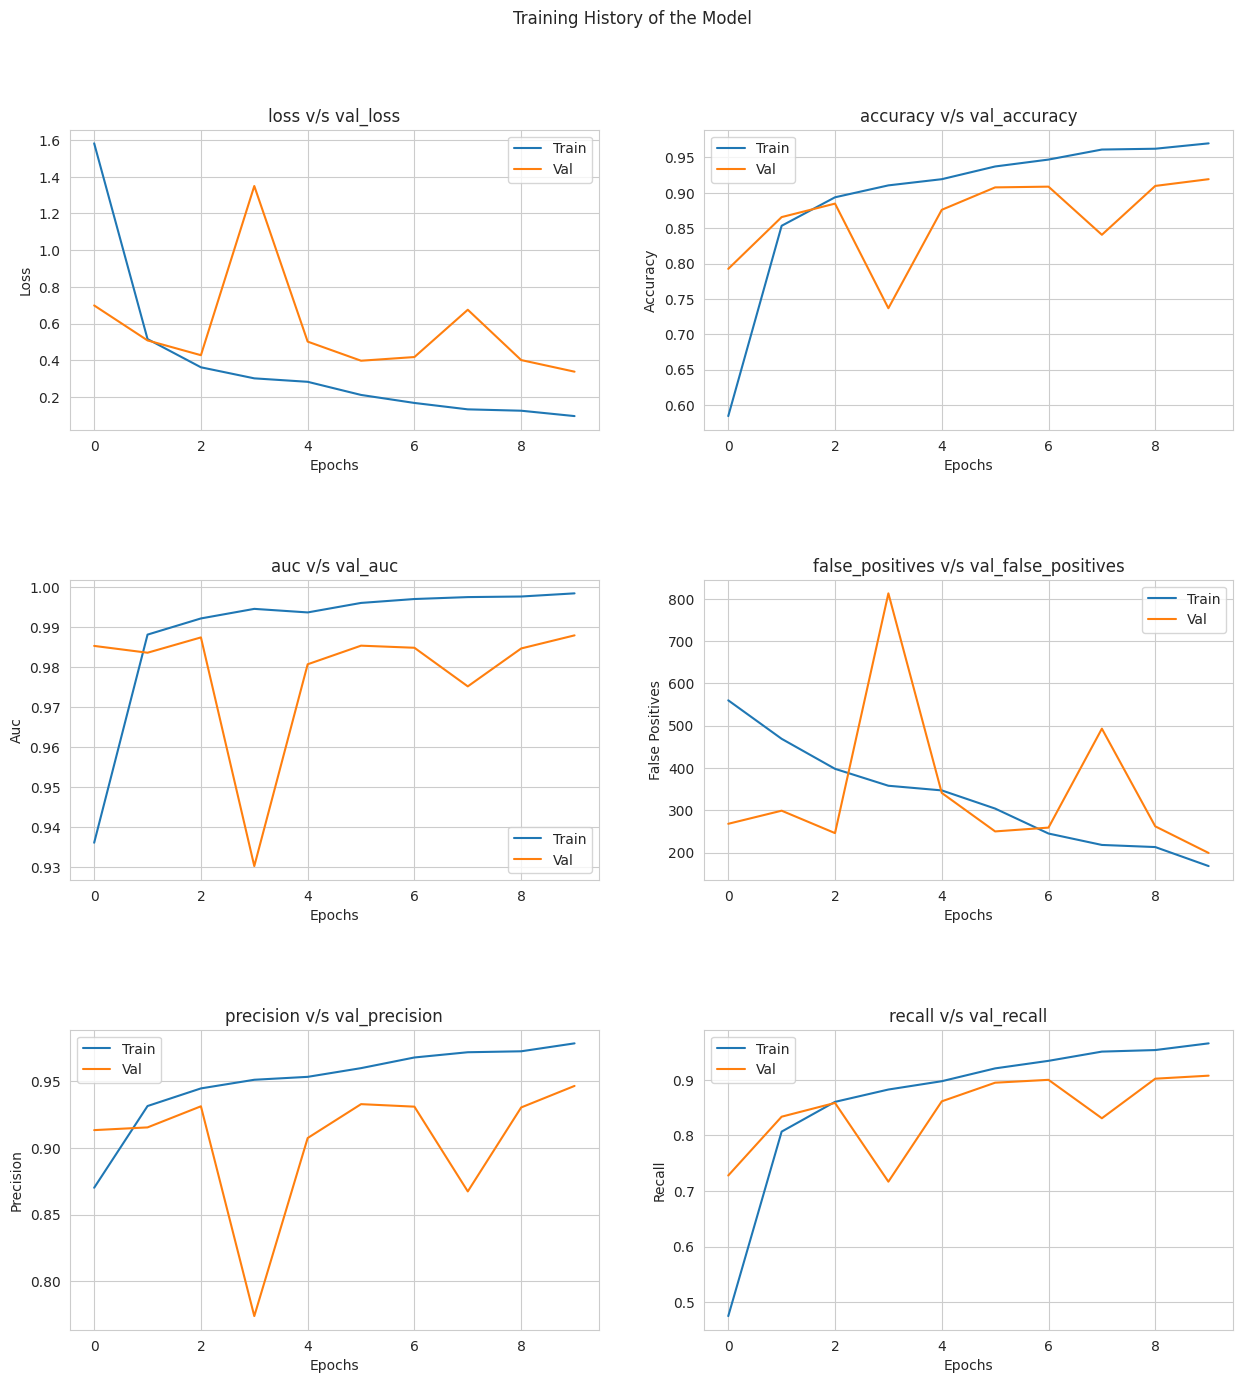

In [18]:
me.training_history()

##### Classification Metrics

62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step
                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00        70
         Agent       0.86      0.81      0.84        70
       Allaple       0.82      0.96      0.88        70
 Alueron.gen!J       1.00      1.00      1.00        35
     Amonetize       0.94      0.94      0.94        70
        Androm       0.71      0.86      0.78        70
       Autorun       0.81      0.87      0.84        70
     BrowseFox       0.95      0.99      0.97        70
   C2LOP.gen!g       0.97      1.00      0.99        35
Dialplatform.B       1.00      0.97      0.98        31
        Dinwod       1.00      0.99      0.99        70
          Elex       0.91      0.97      0.94        70
        Expiro       0.82      0.80      0.81        70
      Fakerean       1.00      1.00      1.00        62
        Fasong       0.97      1.00      0.99        70
       HackKMS       1.00      1.00      1.00        70
     

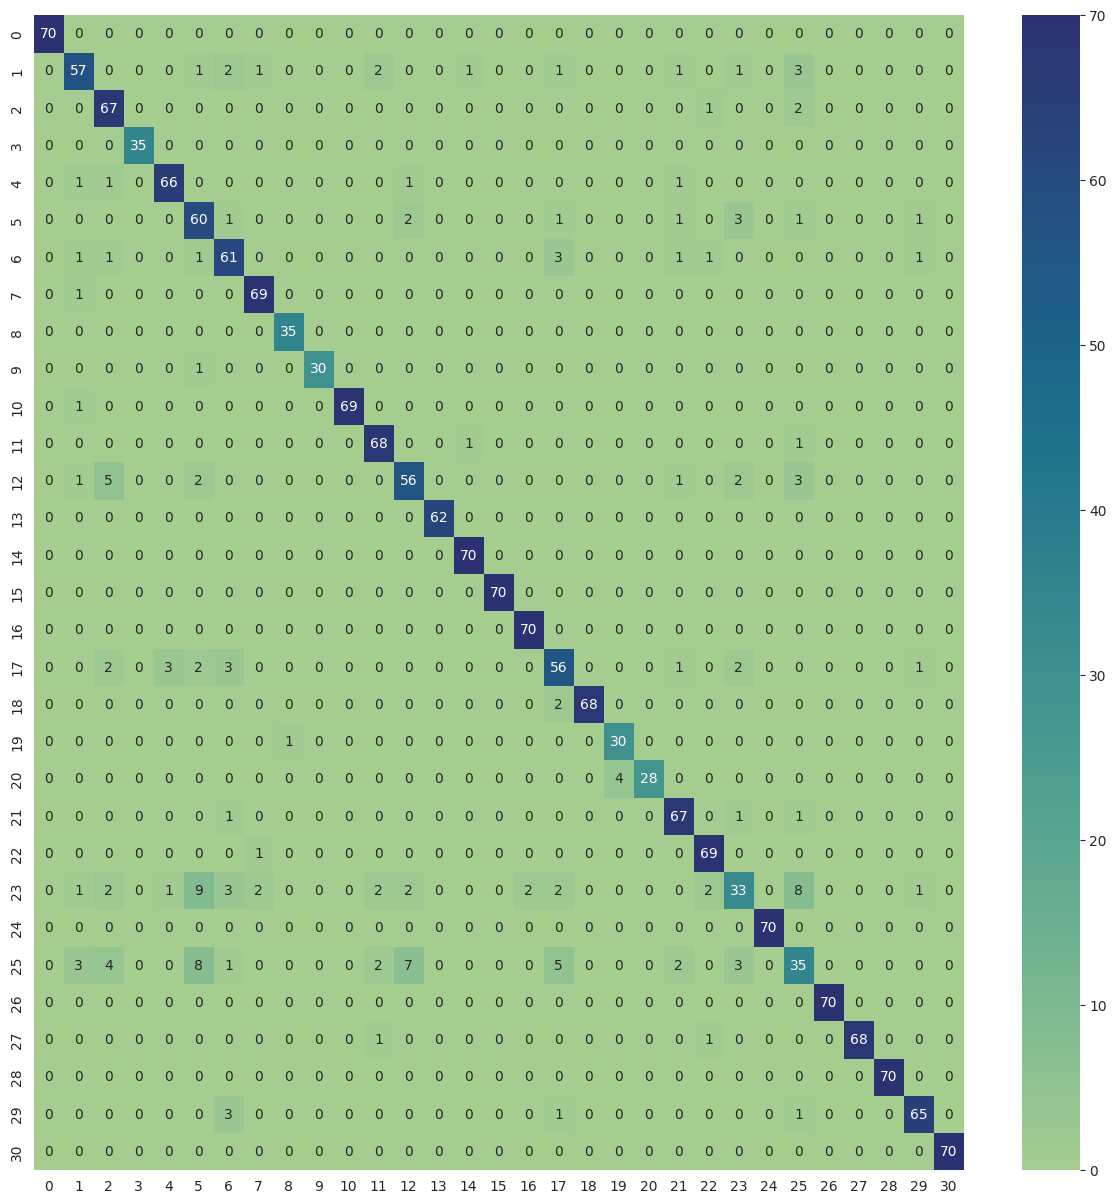

In [19]:
me.predict()
me.class_report()

#### Saving essential data

In [20]:
blended_models["XceptionNet"] = {"Ground Truth": test.labels.tolist(), 
                                 "Predictions":np.array(me.predictions).tolist(), 
                                 "History": history.history}

#### Model Training 

In [ ]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "malimg",malimg_dir, 
                                        (75, 75),
                                        cnns.EfficientNetB0(include_top=False, 
                                                            input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

#### Model Evaluation

##### Initialization of the Evaluator

In [ ]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

In [ ]:
me.training_history()

##### Classification Metrics

In [ ]:
me.predict()
me.class_report()

#### Saving essential data

In [ ]:
malimg_models["EfficientNetB0"] = {"Ground Truth": test.labels.tolist(), 
                                   "Predictions":np.array(me.predictions).tolist(), 
                                   "History": history.history}

#### Model Training

In [ ]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "malevis",malevis_dir, 
                                        (200,200),
                                        cnns.EfficientNetB0(include_top=False, 
                                                            input_shape=(200, 200, 3)), 
                                        25, "val", 
                                        False, 8)

#### Model Evaluation

##### Initialization of the Evaluator

In [ ]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

In [ ]:
me.training_history()

##### Classification Metrics

In [ ]:
me.predict()
me.class_report()

#### Saving essential data

In [ ]:
malevis_models["EfficientNetB0"] = {"Ground Truth": test.labels.tolist(), 
                                    "Predictions":np.array(me.predictions).tolist(), 
                                    "History": history.history}

### Blended Dataset

#### Model Training

In [ ]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.EfficientNetB0(include_top=False, 
                                                            input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

#### Model Evaluation

#### Model Training

In [ ]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.InceptionResNetV2(include_top=False, 
                                                               input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

#### Model Evaluation

##### Initialization of the evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

In [ ]:
me.training_history()

##### Classification Metrics

In [ ]:
me.predict()
me.class_report()

#### Saving essential data

In [ ]:
malimg_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(), 
                                      "Predictions":np.array(me.predictions).tolist(), 
                                      "History": history.history}

### Malevis Dataset

#### Model Training

In [ ]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "malevis",malevis_dir, (200,200),
                                        cnns.InceptionResNetV2(include_top=False, input_shape=(200, 200, 3)), 
                                        25, "val", False, 8)

#### Model Evaluation

##### Initialization of the evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

In [ ]:
me.training_history()

##### Classification Metrics

In [ ]:
me.predict()
me.class_report()

#### Saving the essential data

In [ ]:
malevis_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(), 
                                       "Predictions":np.array(me.predictions).tolist(), 
                                       "History": history.history}

### Blended Dataset

#### Model Training

In [ ]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.InceptionResNetV2(include_top=False, 
                                                               input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

#### Model Evaluation

##### Initialization of the evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

In [ ]:
me.training_history()

##### Classification Metrics

In [ ]:
me.predict()
me.class_report()

#### Saving essential data

In [ ]:
blended_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(), 
                                       "Predictions":np.array(me.predictions).tolist(), 
                                       "History": history.history}

# Saving all the model related information

In [21]:
with open("blended_models.json", 'w') as fp:
    json.dump(blended_models, fp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


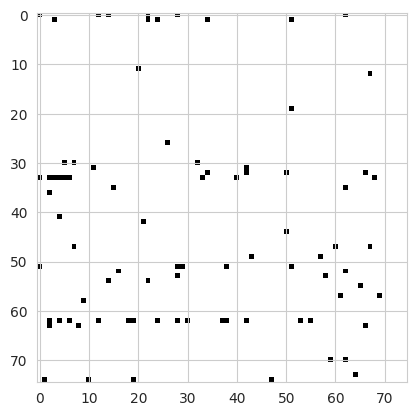

In [55]:
image = tf.keras.preprocessing.image.load_img('upc.exe.png', target_size=(75,75,3))
img=tf.keras.preprocessing.image.img_to_array(image)
plt.imshow(img)
predictions=model.predict(np.array([img]))

In [ ]:
malimg_model_comp = ModelComparison("malimg_models.json", 
                                    "Malimg dataset")

### Training History Comparison

In [ ]:
malimg_model_comp.training_history()

### Classification Metrics-based comparison

In [ ]:
malimg_model_comp.compare_performance()

In [ ]:
malevis_model_comp = ModelComparison("malevis_models.json", 
                                     "Malevis dataset")

### Training History Comparison

In [ ]:
malevis_model_comp.training_history()

### Classification Metrics-based comparison

In [ ]:
malevis_model_comp.compare_performance()

In [56]:
predictions

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [57]:
test.class_indices.keys()

dict_keys(['Adposhel', 'Agent', 'Allaple', 'Alueron.gen!J', 'Amonetize', 'Androm', 'Autorun', 'BrowseFox', 'C2LOP.gen!g', 'Dialplatform.B', 'Dinwod', 'Elex', 'Expiro', 'Fakerean', 'Fasong', 'HackKMS', 'Hlux', 'Injector', 'InstallCore', 'Lolyda.AA1', 'Lolyda.AA2', 'MultiPlug', 'Neoreklami', 'Neshta', 'Regrun', 'Sality', 'Snarasite', 'Stantinko', 'VBA', 'VBKrypt', 'Vilsel'])

In [58]:

keys = np.array(list(test.class_indices.keys()))

In [59]:
keys

array(['Adposhel', 'Agent', 'Allaple', 'Alueron.gen!J', 'Amonetize',
       'Androm', 'Autorun', 'BrowseFox', 'C2LOP.gen!g', 'Dialplatform.B',
       'Dinwod', 'Elex', 'Expiro', 'Fakerean', 'Fasong', 'HackKMS',
       'Hlux', 'Injector', 'InstallCore', 'Lolyda.AA1', 'Lolyda.AA2',
       'MultiPlug', 'Neoreklami', 'Neshta', 'Regrun', 'Sality',
       'Snarasite', 'Stantinko', 'VBA', 'VBKrypt', 'Vilsel'], dtype='<U14')

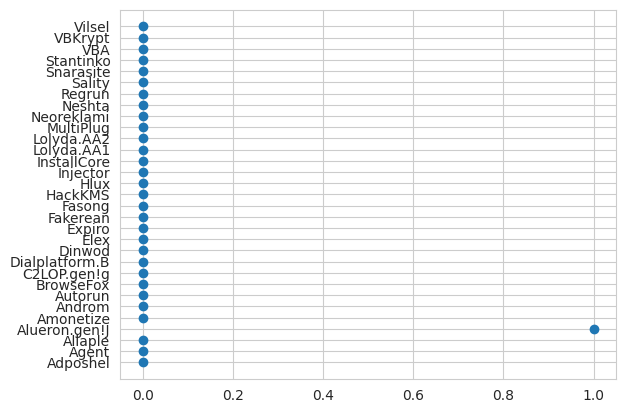

In [60]:
plt.scatter(predictions, keys)